# Week 9: Residual networks

## General instructions

Each week you will be given an assignment related to the associated module. You have roughly one week to complete and submit each of them. There are 3 weekly group sessions available to help you complete the assignments. Attendance is not mandatory but recommended. However, assignments are graded each week and not submitting them or submitting them after the deadline will give you no points.

**FORMAT**: Jupyter notebook **(single file, not in a zip please!)**

**DEADLINE**: Sunday 7th March, 23:59

## Introduction

The objective of this assignment is to get a better intuition as to why residual networks work in practice. More particularly, we will investigate how adding skip connections to a feeforward neural network affects its gradient when combined with carefull initialization of the weights and biases and batch normalization. In all the present work, **we will solely investigate networks' initialization, that is the statistics of sampled neural networks without any training.** We will in particular emphasize how the depth of feedforward neural networks tends to "break" the gradients, which is known to make training much more difficult. 

Observing the gradients is made difficult by the fact that a neural network typically has many variables. To tackle this problem, rather than computing the gradients with respect to the network's parameters as you are now used to, we will instead compute the gradients with respect to the input data. This is meaningful since by the chain rule, the derivatives with respect to inputs are connected to the derivatives with respect to parameters. Furthermore, we will investigate a neural network $x \mapsto f(x)$ mapping $\mathbb{R}$ to $\mathbb{R}$, making it convenient for us to investigate the one dimensional derivatives with respect to inputs. Since we are interested in observing how network depth negatively affects the structure of gradients, we will use a simple grid of uniformly spaced data points ranging from -1 to 1 as input for our network. The exact structure of the neural network is given in the image below:

![title](a_simple_NN-1.png)


Your task is to complete all the cells from the notebook (more detailed instructions are provided in each cell). **In the last cell, you will be asked to provide a thorough visualization (with plots !) and analysis of your experiments. Do not take this lightly as it will be the most important aspect for the grading.**


## Andrew's Videos related to this week's assignment

- [C4W2L03 ResNets](https://www.youtube.com/watch?v=ZILIbUvp5lk&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=14)
- [C4W2L04 Why ResNets work](https://www.youtube.com/watch?v=RYth6EbBUqM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=15)

## Going further

- https://arxiv.org/pdf/1702.08591.pdf
- https://arxiv.org/pdf/1805.07477.pdf


# Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn  as sns

torch.backends.cudnn.benchmark = True

# Utility functions

(You will use these later !)

In [2]:
def compute_correlation(array):
    correlation = np.corrcoef(array, rowvar=False)
    autocorrelation = correlation[:,0]
    return correlation, autocorrelation

def visualize_white_noise(num_vars, num_samples, figsize, color):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle("White noise: " + "$w_n \\sim \\mathcal{N}(0,\\sigma)\\quad \\forall n$")
    white_noise = np.random.randn(num_samples, num_vars)
    correlation, autocorrelation = compute_correlation(white_noise)
    axes[0].plot(np.arange(num_vars), white_noise.mean(axis=0), color=color)
    axes[1].plot(np.arange(num_vars), autocorrelation, color=color)
    sns.heatmap(correlation, cbar=True, xticklabels=False, yticklabels=False, ax=axes[2])
    axes[0].set_title("Mean")
    axes[1].set_title("Autocorrelation function")
    axes[2].set_title("Correlation matrix")
    axes[0].set_xlabel("n", fontsize="x-large")
    axes[1].set_xlabel("k", fontsize="x-large")
    axes[0].set_ylabel("$E(w_n)$", fontsize="x-large")
    axes[1].set_ylabel("$\\rho_w(0,0+k)$", fontsize="x-large")
    plt.show()

# Gradient computation

In [3]:
def compute_gradient_wrt_input(neural_network, x):
    '''
    
    Input: 
        -neural_network: a neural network f
        -x: input data x=[x1,...,xk] (1D tensor)
        
    Output:
        -gradient: the gradient of the neural network wrt x, df/dx=[df/dx1,...,df/dxk]
        
    TODO: 
    1) Disable autograd for all the network's parameters.
    2) Enable autograd for x.
    3) Implement a forward pass followed by a backward pass on the neural network with input data x.
    4) Collect the gradient of the neural network in x.
    
    Note: We do not want to update the parameters of the neural network, thus we don't need an optimizer.
    
    '''
    for param in neural_network.parameters():
        neural_network.requires_grad = False
    
    x.requires_grad = True
    
    out = neural_network(x).sum()
    out.backward()
    
    gradient = x.grad
    
    return gradient

# Residual neural network

In [4]:
class residual1D(nn.Module):
    '''
    
    TODO:
    1) Construct a feedforward neural network consisting of d layers such that:
        -Each layer is exactly "linear->batch_norm1d->ReLU".
        -Layer 0 has in_features=1, out_features=n.
        -Layers 1 to d-2 have in_features=n, out_features=n.
        -Layer d-1 has in_features=n, out_features=1.
        -Each layer has its linear component initialized such that weight, bias ~ N(0,sigma²=1/in_features) 
    2) Implement the forward function of the neural network: a_{l+1} = layer_l(a_l), (a_0 = x).
    3) Implement an alternative forward pass with skip connections: a_{l+1} = a_l + beta * layer_l(a_l), (a_0 = x).
    
    '''
    
    def __init__(self, d, n, beta, net_type):
        super(residual1D, self).__init__()
        
        self.d = d
        self.n = n
        self.beta = beta
        self.net_type = net_type
        self.linears = nn.ModuleList()
        self.relu = nn.ReLU()
        
        # Layers
        self.linearIn = nn.Linear(1,n)
        nn.init.normal_(self.linearIn.weight, 0.0, 1)
        nn.init.normal_(self.linearIn.bias, 0.0, 1)
        self.bn1 = nn.BatchNorm1d(num_features=n)
        
        for i in range(d):
            linear = nn.Linear(n,n)
            nn.init.normal_(linear.weight, 0.0, np.sqrt(1/n))
            nn.init.normal_(linear.bias, 0.0, np.sqrt(1/n))
            
            bn = nn.BatchNorm1d(num_features=n)
            nn.init.normal_(bn.weight, 0.0, np.sqrt(1/n))
            nn.init.normal_(bn.bias, 0.0, np.sqrt(1/n))
            
            self.linears.append(linear)
            self.linears.append(bn) # nn.BatchNorm1d(num_features=n)
        
        self.linearOut = nn.Linear(n,1)
        nn.init.normal_(self.linearOut.weight, 0.0, np.sqrt(1/n))
        nn.init.normal_(self.linearOut.bias, 0.0, np.sqrt(1/n))
        self.bnOut = nn.BatchNorm1d(num_features=1)
        
    def forward(self, x):
        out = None
        x = x.view(-1,1)
        
        if self.net_type == 'residual':
            
            #self.relu(self.bn1(x + self.beta*self.linearIn(x))) 
            x = x + self.beta*self.relu(self.bn1(self.linearIn(x)))
            for idx in range(0, len(self.linears), 2):
                linear = self.linears[idx]
                bn = self.linears[idx + 1]
                x = x + self.beta*self.relu(bn(linear(x)))
            out = x + self.beta*self.relu(self.bnOut(self.linearOut(x)))
            
            
            #out = self.relu(self.bnOut(x + self.beta*self.linearOut(x)))
            
        elif self.net_type == 'feedforward':
            #x = x.view(-1, 1)
            x = self.relu(self.bn1(self.linearIn(x)))
            
            for idx in range(0, len(self.linears), 2):
                linear = self.linears[idx]
                bn = self.linears[idx + 1]
                x = self.relu(bn(linear(x)))
            
            out = self.relu(self.bnOut(self.linearOut(x)))

        return out

# Experiment code

In [28]:
def inspect_gradients(network_type, x, depths, num_iters, seed):
    hidden_units = 128
    beta = 0.2
    '''
    Input:
        -network_type: type of neural network (either "feedforward" or "residual")
        -x: input data x=[x1,...,xk] (1D tensor)
        -depths: network depths to inspect
        -num_iters: number of iterations (number of random sampling of neural networks)
        -seed: self-explanatory
    
    TODO: 
    1) Seed pytorch
    2) For every depth, for every iteration:
        -Initialize a neural network of the desired type ("feedforward" or "residual") and depth.
        -Compute and store the gradient of the sampled network wrt x.
        -Stack the computed gradient vertically inside an array of shape [num_iters, X.shape[0]].
    3) For every depth:
        -Extract the mean of the gradients (with respect to the iterations).
        -Extract the correlation matrix and the autocorrelation function of the gradients.
    4) Visualize the statistics extracted in 3).
    
    Note: For 3) and 4), see Utility functions.
    '''
    
    torch.manual_seed(seed)
    
    for depth in depths:
        store = torch.zeros((num_iters, x.shape[0]))
        for iteration in range(num_iters):
            
            net = residual1D(depth, hidden_units, beta, network_type)
            gradient = compute_gradient_wrt_input(net,x)
            store[iteration, :] = gradient

        mean = torch.mean(store, dim = 0)
        corr, autocorr = compute_correlation(store)
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        
        fig.suptitle(f"depth: {depth}")
        
        axes[0].plot(np.arange(x.shape[0]), mean, color = "blue")
        axes[0].set_title("Mean")
        
        axes[1].plot(np.arange(x.shape[0]), autocorr, color="red")
        axes[1].set_title('AutoCorr')
        
        sns.heatmap(corr, cbar=True, xticklabels=False, yticklabels=False, ax=axes[2])
        axes[2].set_title('Corr')
        
        plt.show()


# Experiments and analysis

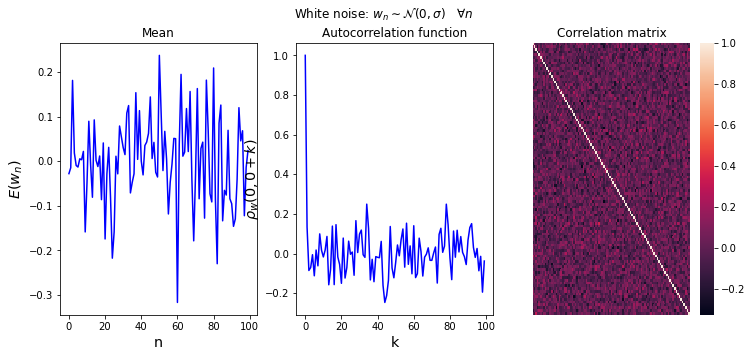

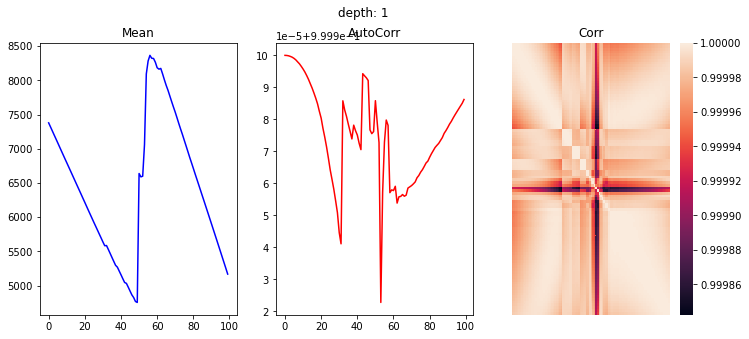

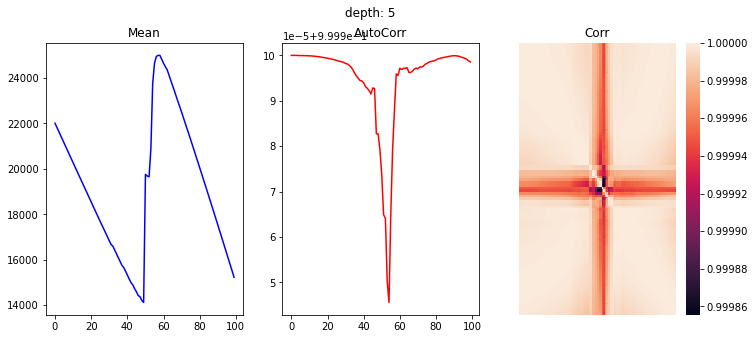

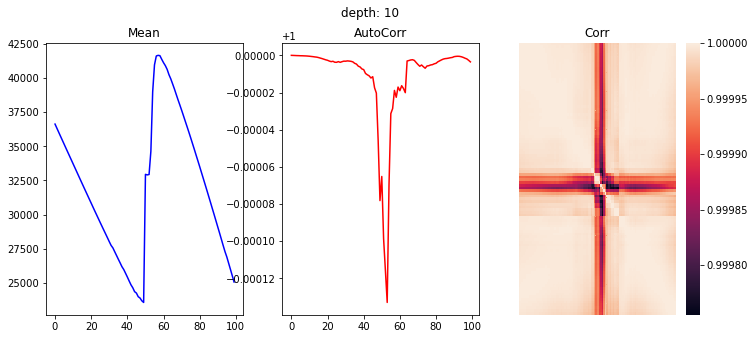

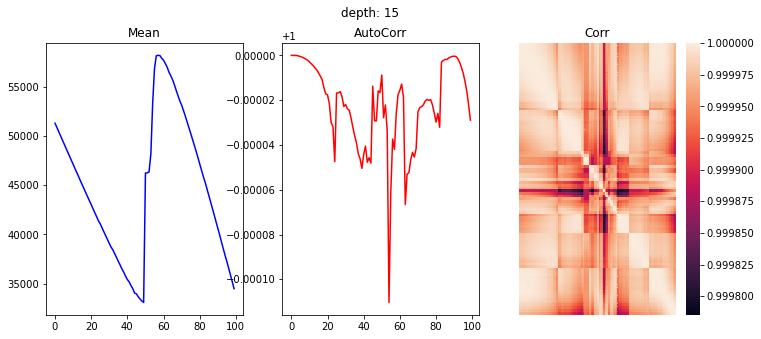

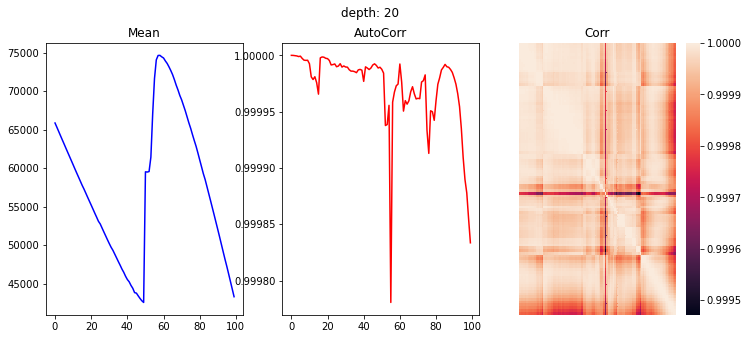

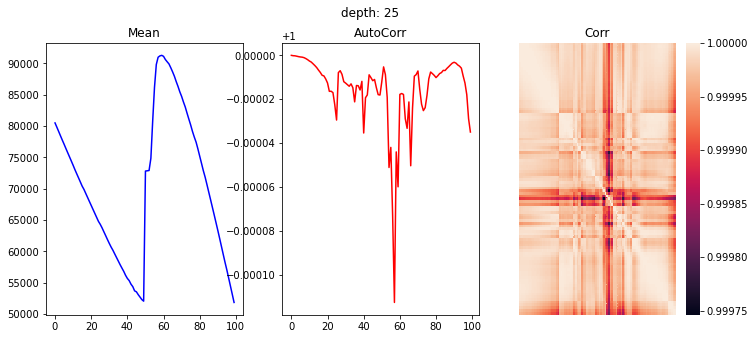

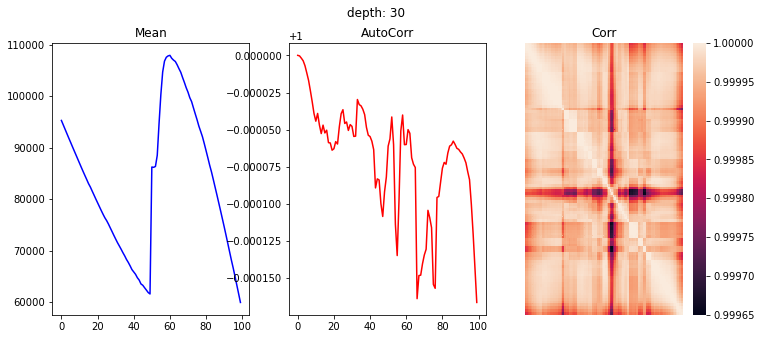

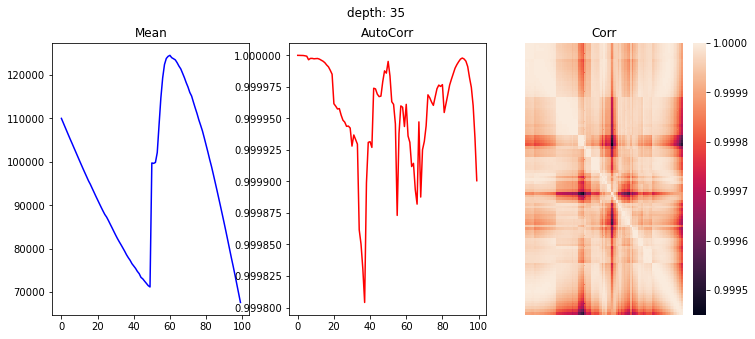

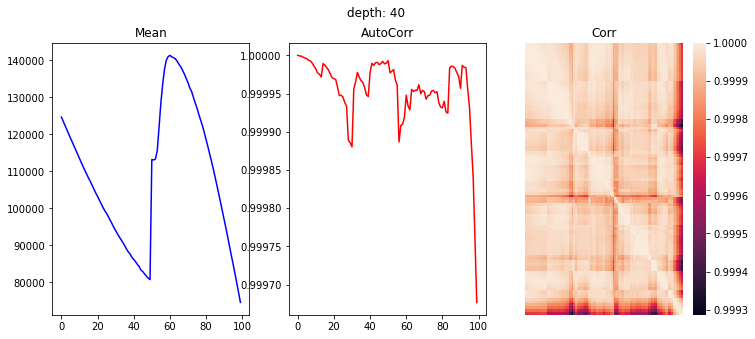

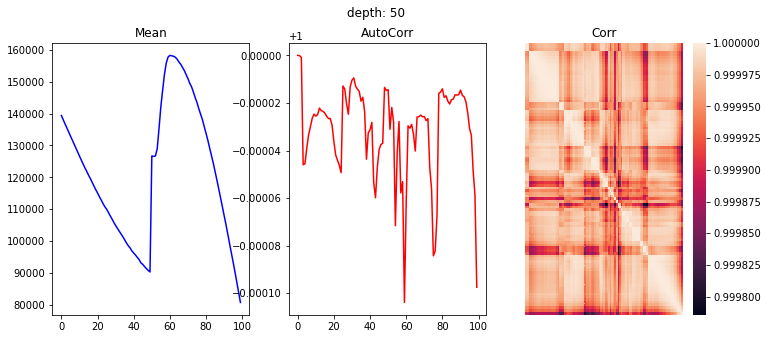

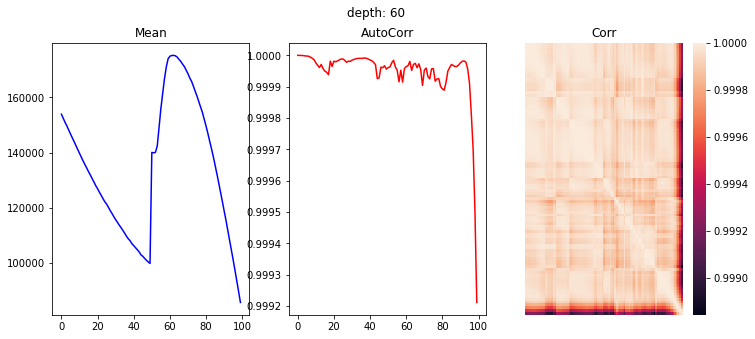

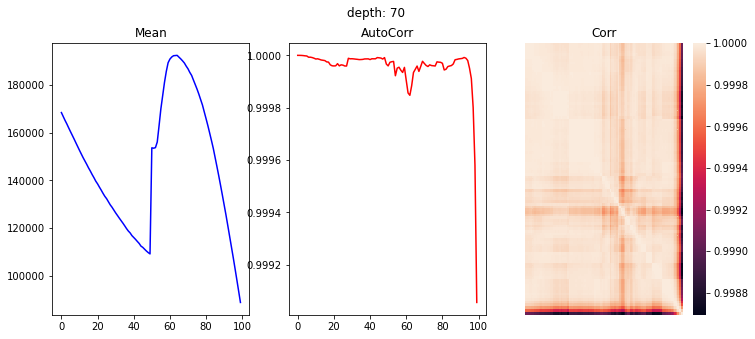

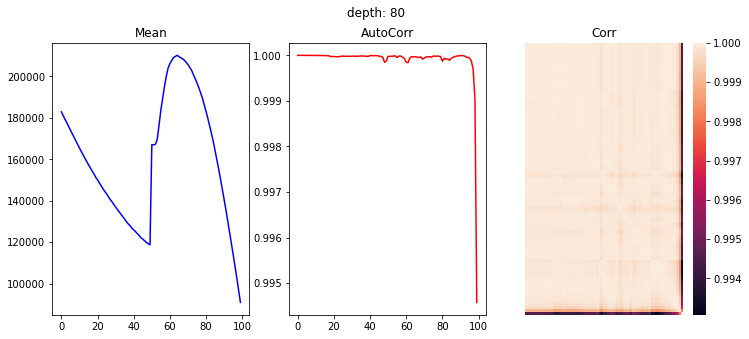

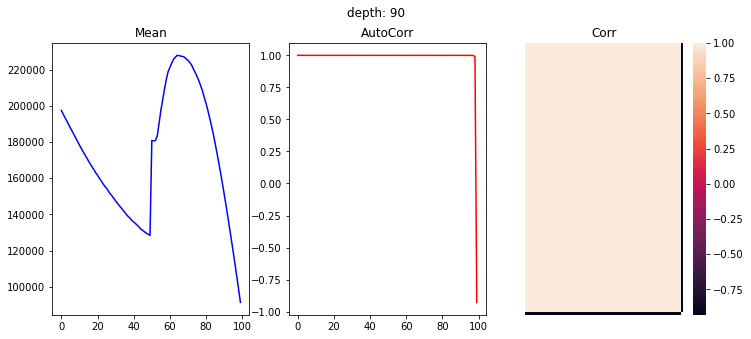

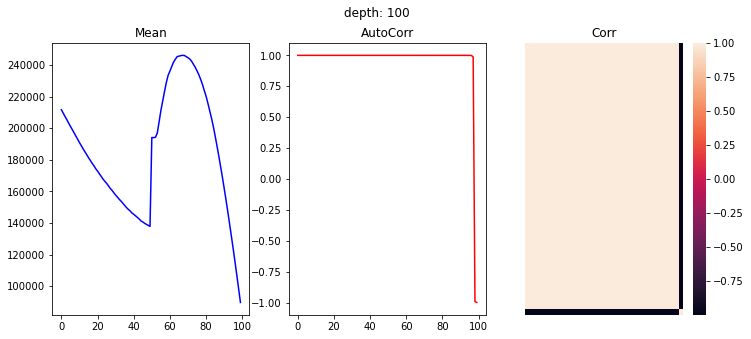

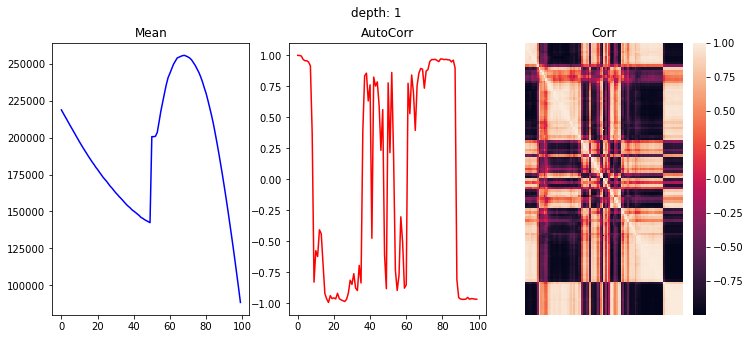

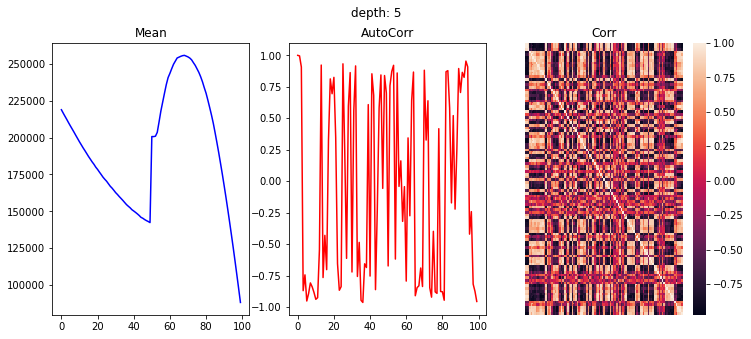

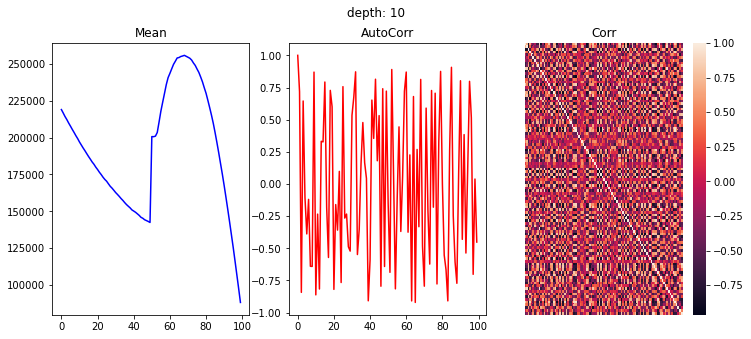

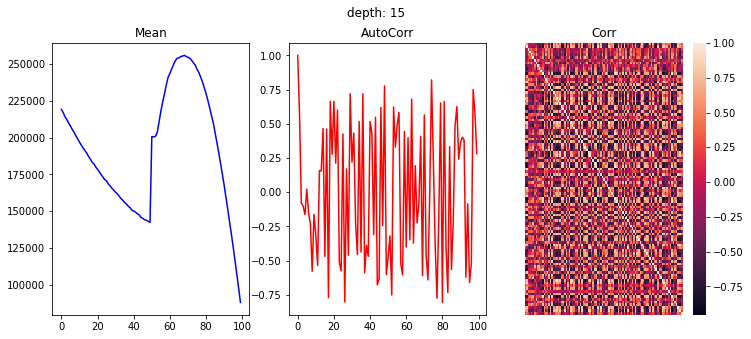

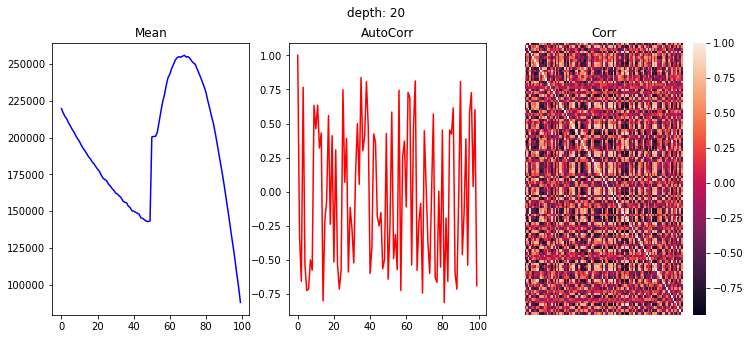

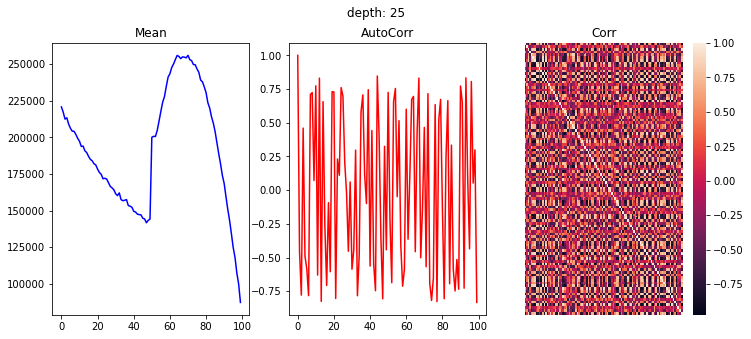

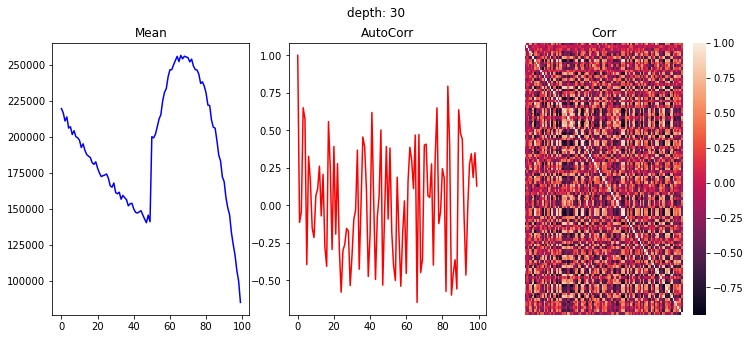

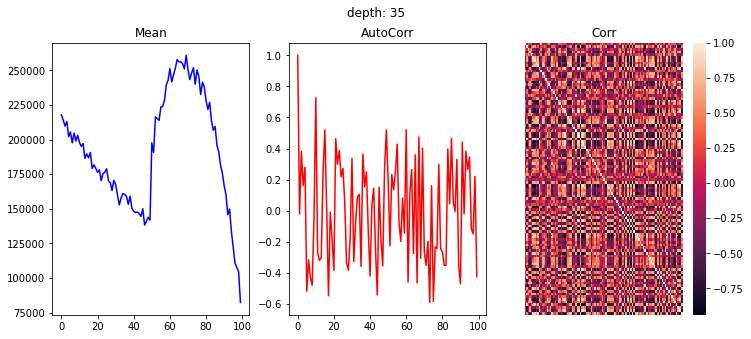

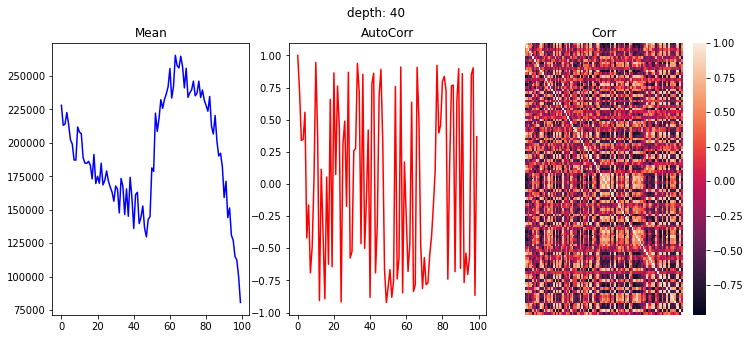

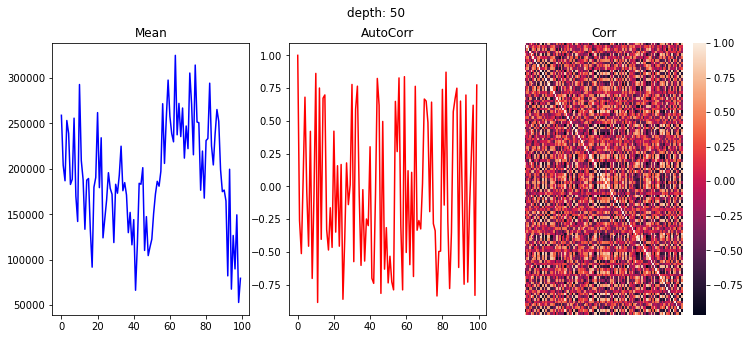

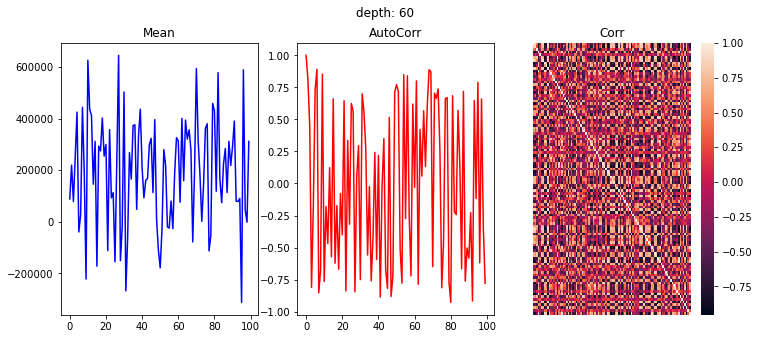

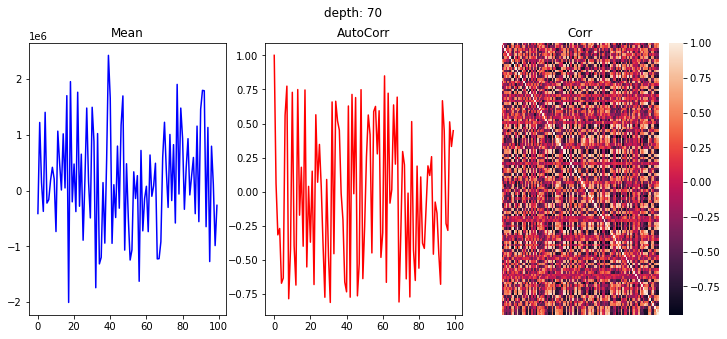

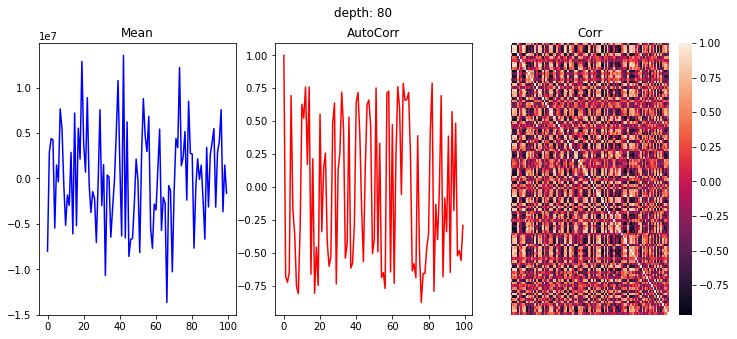

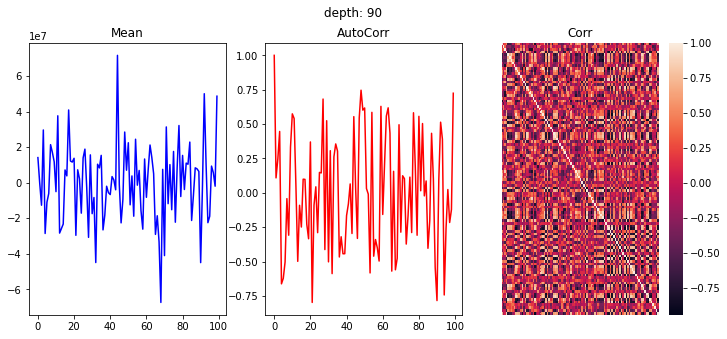

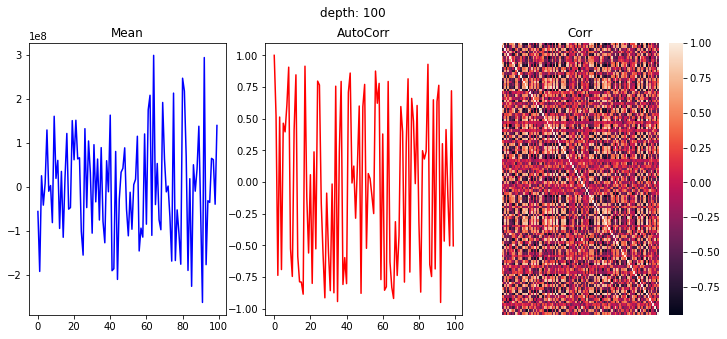

In [29]:
'''
TODO:
1) Visualize white noise.
2) Create a 1D data tensor x consisting of (>= 100) points uniformly spaced between [-1,1]
3) Visualize gradients wrt x of feedforward neural networks with various depths.
4) Visualize gradients wrt x of residual neural networks with various depths.
5) ANALYSIS OF YOUR RESULTS (in a markdown cell): 
    -Give two problems occuring with the gradients of deep feedforward neural networks at initialization.
    -From the observation of your plots, to which extent these problems were solved by 
     the combination of proper initialization + batch normalization + skip connections ?
    -What is the maximal depth you can reach with your feedforward network before "breaking" the gradients ?
    -Same question with your residual network.
    -What is the effect of the parameter beta in your residual neural network ?
    
'''
x = torch.linspace(-1, 1, 100)
num_iters = 100
depths = [1,5,10,15,20,25,30,35,40,50,60,70,80,90,100]
figsize = (12, 5)


visualize_white_noise(len(x),num_iters, figsize, "blue")
inspect_gradients('residual', x, depths, num_iters, 5)
inspect_gradients('feedforward', x, depths, num_iters, 5)


### Quick analysis
    -Give two problems occuring with the gradients of deep feedforward neural networks at initialization.
    -From the observation of your plots, to which extent these problems were solved by 
     the combination of proper initialization + batch normalization + skip connections ?
    -What is the maximal depth you can reach with your feedforward network before "breaking" the gradients ?
    -Same question with your residual network.
    -What is the effect of the parameter beta in your residual neural network ?
   
#### Problems with gradients of deep feedforward networks
1. Vanishing gradients: This happens when the neural network is unable to pass useful information deep into the network. And as a result is unable to effectively learn.
2. Exploding gradients: This happens when the activation functions derivative can take on larger values. Thus the weights can suddenly grow/get updated to basically inf

##### To which extent were these problems solved
Well its not entirely intuitive to read the graphs and make some meaningful conclusion (Not impossible that this is due to some faulty code). But when we compare the white noise, gradients of the feedforward network and the gradients of the residual network we can still see some differences and similarities. For instance the feedforward network and the residual are very very different in structure. The feedforward is chaotic, with many correlations and negative correlations all over the place. Whereas the residual network is more immutable so to speak. It only looks like there are a bunch of changes because the scale of the heatmap changes. In reality its almost identical all the way to 100. Around layer 70-80 (with beta 0.2) and around layer 50 (beta = 0.3) there appears this strange artifact on the bottom/right hand side of the correlation heatmap, im not entirely sure what this is about.

##### Maximum depth of feedforward network
In my case it appears that the gradients start breaking pretty early on. Even appearant in layers 5-10-20. This chaos is steadily spreading as we get deeper. (Although some structure sort of appears every now and again)

##### Maximum depth of residual network
Its not that easy to tell really... It doesnt seem that effected even in the deeper layers. I did encounter this strange artifact, and im guessing its not a good sign. So probably around layer 70-80???

##### The beta param
The the parameter seems to me like a exponential moving average parameter. Thus deciding how many of the previous layers should be included in the current layer. The strange artifact appears quicker the higher the beta value. 